### Computing HPPC power limits
The code in this notebook computes HPPC power limits based on knowledge of true SOC and also based on an SOC estimate (plus bounds) output by an SPFK.

The code considers a dataset where profiles of power versus time were demanded from a cell, and the resulting data were used by an SPKF to estimate SOC. "True" SOC was also available from the lab equipment, since the test was calibrated in the ways you learned in the second course of the specialization.

The code first computes effective resistances needed by the HPPC methods, then uses those in the HPPC method. Results are plotted at the end.

In [1]:
% Parameters
addpath ./readonly/ 
load('./readonly/CellModel.mat');               % ESC cell model
load('./readonly/CellData.mat');                % time/current/voltage/soc
load('./readonly/spkfData.mat');                % results of SPKF SOC estimation
  
% Cell Configuration
T       = 25;                                   % (degC) ambient temperature
Thorz   = 15;                                   % (s) horizon time
z       = 0.5;                                  % [] initial cell SOC
Ns      = 1;                                    % [] number of series cells
Np      = 1;                                    % [] number of parallel cells

% Operational Limits
zmin = 0.1;     zmax = 0.9;                     % [] soc limits
vmin = 2.8;     vmax = 4.3;                     % (V) voltage limits
imin = -200;    imax = 350;                     % (A) current limits
pmin = -inf;    pmax = inf;                     % (W) power limits

% Effective Resistances
Q    = getParamESC('QParam',T,model); 
iChg = 10*Q*[zeros(5,1); -ones(Thorz,1); zeros(5,1)];  % [A] charge pulse
iDis = 10*Q*[zeros(5,1);  ones(Thorz,1); zeros(5,1)];  % [A] discharge pulse
[vk,~,~,~,~] = simCell(iChg,T,model,1,z,0,0);
dvChg = max(vk)-vk(1);
iChg  = min(iChg);
RChg  = abs(dvChg/iChg);
fprintf('Rchg = %2.4f (mOhm)\n',1000*RChg);

[vk,~,~,~,~] = simCell(iDis,T,model,1,z,0,0);
dvDis = min(vk)-vk(1);
iDis  = max(iDis);
RDis  = abs(dvDis/iDis);
fprintf('Rdis = %2.4f (mOhm)\n',1000*RDis);

% HPPC Power Estimation: Truth
OCV      = OCVfromSOCtemp(soc,T,model);
iDisMaxV = (OCV-vmin)/RDis;
iDisMaxZ = (soc - zmin)*3600*Q/10;
iDisMax  = max(0,min([iDisMaxV;iDisMaxZ;imax*ones(size(soc))]));
pDisMax  = min(vmin*iDisMax,pmax*ones(size(soc)));
iChgMinV = (OCV-vmax)/RChg;
iChgMinZ = (soc - zmax)*3600*Q/10;
iChgMin  = max([iChgMinV;iChgMinZ;imin*ones(size(soc))]);
pChgMin  = min(0,max(vmax*iChgMin,pmin*ones(size(soc))));
HPPC.pDisMax = pDisMax;
HPPC.pChgMin = pChgMin;

% HPPC Power Estimation: SPKF
OCVDis   = OCVfromSOCtemp(spkfSOC-bounds,T,model);
OCVChg   = OCVfromSOCtemp(spkfSOC+bounds,T,model);
iDisMaxV = (OCVDis-vmin)/RDis;
iDisMaxZ = (spkfSOC-bounds - zmin)*3600*Q/10;
iDisMax  = max(0,min([iDisMaxV;iDisMaxZ;imax*ones(size(soc))]));
pDisMax  = min(vmin*iDisMax,pmax*ones(size(soc)));
iChgMinV = (OCVChg-vmax)/RChg;
iChgMinZ = (spkfSOC+bounds - zmax)*3600*Q/10;
iChgMin  = max([iChgMinV;iChgMinZ;imin*ones(size(soc))]);
pChgMin  = min(0,max(vmax*iChgMin,pmin*ones(size(soc))));
spkfHPPC.pDisMax = pDisMax;
spkfHPPC.pChgMin = pChgMin;

Rchg = 4.1188 (mOhm)
Rdis = 4.1681 (mOhm)


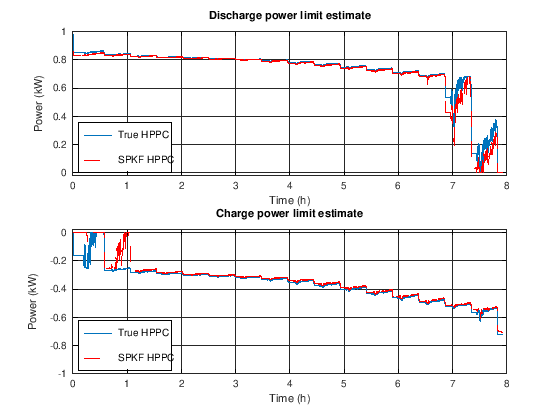

In [2]:
% Discharge Power Estimation Figure
subplot(2,1,1);
plot(time/3600,HPPC.pDisMax/1000,'-','LineWidth',1.5); hold on
plot(time/3600,spkfHPPC.pDisMax/1000,'r--','LineWidth',1.5);
xlabel('Time (h)');
ylabel('Power (kW)');
title('Discharge power limit estimate');
legend('True HPPC','SPKF HPPC','Location','SouthWest');
grid on; hold off; ylim([-0.02 1.0])

% Charge Power Estimation Figure
subplot(2,1,2);
plot(time/3600,HPPC.pChgMin/1000,'-','LineWidth',1.5); hold on
plot(time/3600,spkfHPPC.pChgMin/1000,'r--','LineWidth',1.5);
xlabel('Time (h)');
ylabel('Power (kW)');
title('Charge power limit estimate');
legend('True HPPC','SPKF HPPC','Location','SouthWest');
grid on; ylim([-1 0.02])

In [3]:
max(abs(HPPC.pChgMin))
max(abs(spkfHPPC.pChgMin))
max(abs(HPPC.pDisMax))
max(abs(spkfHPPC.pDisMax))

ans =  724.33
ans =  704.56
ans =  980.00
ans =  855.48
